#Convolutional Neural Networks and Reinforcement Learning

##Convolutional Neural Networks

###Object Detection in Images

One popular architecture is the Faster R-CNN, however, implementing Faster R-CNN from scratch requires a lot of code and might be quite complex. Alternatively, there are deep learning frameworks, like TensorFlow and PyTorch, that offer pre-trained models. These models can be used out-of-the-box or can be fine-tuned on a specific task.

In this case, we will use TensorFlow's Object Detection API to detect objects in images using a pre-trained model. For this, we need to clone the models repository from TensorFlow's GitHub. TensorFlow's Object Detection API also requires the installation of certain packages. Please follow the installation instructions in this link: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md . You can also check a step by step tutorial for Tensorflow Object detection API on this link: https://www.youtube.com/watch?v=XoMiveY_1Z4

In this example, I'll show you how to use a Faster RCNN and a technique called Transfer Learning to train an object detector on a smaller dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install pycocotools torch torchvision

####Create your own Dataset

With pycocotools, I created my own Dataset class to load the annotation files and opening the corresponding image.

In [ ]:
#Import the libraries and packages
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

In [ ]:
#Create the dataset
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None): #To initialize the class
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):  #This will fetch the data sample for a given key
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation


    def __len__(self):
        return len(self.ids)

In COCO format, the bounding box is given as [xmin, ymin, width, height]; however, Faster R-CNN in PyTorch expects the bounding box as [xmin, ymin, xmax, ymax].

In [ ]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

####Setup the dataloaders

 Once I had created my own Dataset class, it was time to set up a DataLoader.

In [ ]:
# path to your own data and coco file
train_data_dir = '/content/drive/MyDrive/lab/Presentations/AI_summer/data/object_detection/my_data/train'
train_coco = '/content/drive/MyDrive/lab/Presentations/AI_summer/data/object_detection/my_data/my_train_coco.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let’s check whether our DataLoader pulls images and annotations iteratively.

In [ ]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)

[{'boxes': tensor([[216., 188., 381., 358.]]), 'labels': tensor([1]), 'image_id': tensor([1]), 'area': tensor([28050.]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[ 78., 257., 330., 433.]]), 'labels': tensor([1]), 'image_id': tensor([2]), 'area': tensor([44352.]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[144.,  78., 487., 342.]]), 'labels': tensor([1]), 'image_id': tensor([5]), 'area': tensor([90552.]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[113., 153., 439., 382.]]), 'labels': tensor([1]), 'image_id': tensor([4]), 'area': tensor([74654.]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[ 59., 113., 325., 542.]]), 'labels': tensor([1]), 'image_id': tensor([3]), 'area': tensor([114114.]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[140., 188., 306., 293.]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([17430.]), 'iscrowd': tensor([0])}]


####Run the model

Now we have prepared our own COCO-formatted data, ready for the Faster R-CNN model. It is straight forward to modify a few parameters in order to customise the model (e.g. number of anchor boxes, etc.). A simplified implementation using some lines from the official tutorial is presented below:

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


# 2 classes; Only target class or background
num_classes = 2
num_epochs = 10
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


Iteration: 1/6, Loss: 1.3358062505722046
Iteration: 2/6, Loss: 1.207190752029419
Iteration: 3/6, Loss: 1.0312312841415405
Iteration: 4/6, Loss: 0.8957648873329163
Iteration: 5/6, Loss: 0.8388086557388306
Iteration: 6/6, Loss: 0.7017772197723389
Iteration: 1/6, Loss: 0.7206340432167053
Iteration: 2/6, Loss: 0.4937475621700287
Iteration: 3/6, Loss: 0.37934157252311707
Iteration: 4/6, Loss: 0.2579633593559265
Iteration: 5/6, Loss: 0.14292806386947632
Iteration: 6/6, Loss: 0.5215708613395691
Iteration: 1/6, Loss: 0.2125845104455948
Iteration: 2/6, Loss: 0.23245087265968323
Iteration: 3/6, Loss: 0.28680849075317383
Iteration: 4/6, Loss: 0.14674566686153412
Iteration: 5/6, Loss: 0.138917937874794
Iteration: 6/6, Loss: 1.011897087097168
Iteration: 1/6, Loss: 0.17154422402381897
Iteration: 2/6, Loss: 0.1764150857925415
Iteration: 3/6, Loss: 0.22009046375751495
Iteration: 4/6, Loss: 0.35481664538383484
Iteration: 5/6, Loss: 0.21292901039123535
Iteration: 6/6, Loss: 0.2594621181488037
Iteration:

###Anomaly Detection in surveillance videos

Anomaly detection is the process of identifying unexpected items or events in data sets, which differ from the norm. And anomaly detection is often applied on unlabeled data which is known as unsupervised anomaly detection. Anomaly detection has two basic assumptions:
* Anomalies only occur very rarely in the data.
* Their features differ from the normal instances significantly.

Anomaly Detection in surveillance videos involves learning patterns in normal behavior and identifying deviations from these patterns as anomalies. The idea is to train a model to reconstruct "normal" frames and then measure the reconstruction error on new data. If the reconstruction error is high, it could be because the model is seeing an "anomaly" it has not seen before.We also need to convert videos into frames before training the model.

If we want to treat the problem as a binary classification problem, we need labeled data and in this case, collecting labeled data is hard because of the following reasons:
* Abnormal events are challenging to obtain due to their rarity.
* There is a massive variety of abnormal events, and manually detecting and labeling such events is a difficult task that requires much manpower.

The above reasons promoted the need to use unsupervised or semi-supervised methods like dictionary learning, Spatio-temporal features, and autoencoders. Unlike supervised methods, these methods only require unlabeled video footages that contain little or no abnormal events that are easy to obtain in real-world applications.

In [1]:
%%capture
!pip install opencv-python keras scikit-learn matplotlib numpy

####Let's download the UCSD Anomaly Detection dataset

We will use the UCSD anomaly detection dataset, which contains videos acquired with a camera mounted at an elevation, overlooking a pedestrian walkway. In normal settings, these videos contain only pedestrians.
* Non-pedestrian entities in the walkway, like bikers, skaters, and small carts.
* Unusual pedestrian motion patterns like people walking across a walkway or at the grass surrounding it.

The UCSD dataset consists of two parts, ped1 and ped2. We will use the ped1 part for training and testing.

In [ ]:
#Download the UCSD Anomaly Detection Dataset
!wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz

In [ ]:
#Extract the tar file
!tar -zxvf /content/UCSD_Anomaly_Dataset.tar.gz

In [1]:
import glob
import numpy as np
from urllib.request import urlopen
import tarfile
import os
import mxnet as mx
from mxnet import gluon
from PIL import Image
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
if not os.path.isfile("UCSD_Anomaly_Dataset.tar.gz"):
  response = urlopen("http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz")
  html = response.read()
  tar = tarfile.open("/content/UCSD_Anomaly_Dataset.tar.gz")
  tar.extractall()
  tar.close()

####Convolutional Autoencoder (CAE)

Let's define the network structure. The encoder consists of two convolutional and two MaxPooling layers. Encoder and Decoder are connected by a fully connected layer. The larger this bottleneck, the more information can be reconstructed. The decoder consists of two Upsampling layers and two Deconvolutions.

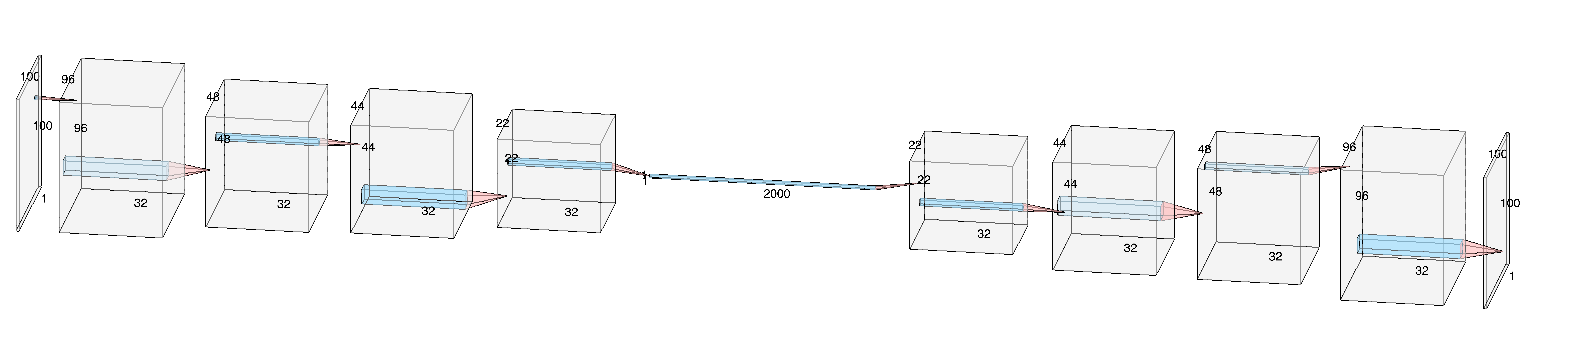

In [3]:
class ConvolutionalAutoencoder(gluon.nn.HybridBlock):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()

        with self.name_scope():
            self.encoder = gluon.nn.HybridSequential()
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Conv2D(32, 5, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.Conv2D(32, 5, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.Dense(2000))

            self.decoder = gluon.nn.HybridSequential()
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(32*22*22, activation='relu'))
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.Conv2DTranspose(32, 5, activation='relu'))
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.Conv2DTranspose(1, kernel_size=5, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        x = self.encoder(x)
        x = self.decoder[0](x)
        x = x.reshape((-1,32,22,22))
        x = self.decoder[1:](x)

        return x

In [4]:
ctx = mx.cpu()
num_epochs = 30
batch_size = 32

Images from the folder UCSDped1 have the format 158x238 pixels. They are rescaled to 100x100 and normalized.

In [ ]:
files = sorted(glob.glob('/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/*/*'))
a = np.zeros((len(files),1,100,100))

for idx, filename in enumerate(files):
    im = Image.open(filename)
    im = im.resize((100,100))
    a[idx,0,:,:] = np.array(im, dtype=np.float32)/255.0

dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size, last_batch='rollover',shuffle=True)
print("Dataset Loaded Successfully!!")

Intialize the network and define loss function.

In [6]:
model = ConvolutionalAutoencoder()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier('gaussian'), ctx=ctx)
loss_function = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 1e-4, 'wd': 1e-5})

The following code defines the training loop:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

####Training the model (CAE)

In [ ]:
!pip install mxnet-mkl

In [8]:
import mxnet as mx

In [ ]:
!pip install --upgrade tensorflow

In [11]:
num_epochs=1

In [13]:
for epoch in range(num_epochs):

    for image_batch in dataloader:

        image = image_batch.as_in_context(ctx)

        with mx.autograd.record():
            output = model(image_batch)
            loss = loss_function(output, image_batch)

        loss.backward()
        optimizer.step(image.shape[0])

Now that the Autoencoder is trained, we can use our test dataset, which contains some anomalies. We focus here on Test024, which is a video sequence with a golf cart that should be detected as anomaly.

In [15]:
files = sorted(glob.glob('/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'))

a = np.zeros((len(files),1,100,100))

for idx,filename in enumerate(files):
    im = Image.open(filename)
    im = im.resize((100,100))
    a[idx,0,:,:] = np.array(im, dtype=np.float32)/255.0

dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=1)

A helper function that will plot input and output images and the differnce between them.

In [16]:
def plot(img, output, diff, H, threshold, counter):

    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()

    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')

    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')

    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1)

    plt.axis('off')

    fig.savefig('/content/drive/MyDrive/lab/Presentations/AI_summer/saved_model/' + str(counter) + '.png')

Let's iterate over the test images. We compute the difference between input and output and create a pixel map H with a 4x4 convolution kernel. If a pixel value in H is larger than 4 times 255 it will be marked as anomaly. The maximum value for each pixel in H is 4x4x255. We perform this step, so that pixels will be marked only when their neighboring pixels are also anomalous.

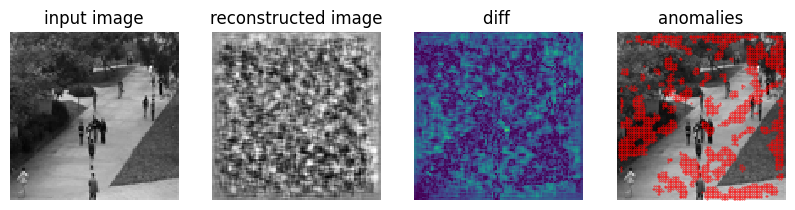

In [17]:
threshold = 4*255
counter = 0
#try:
 #   os.mkdir("images")
#except:
 #   pass

for image in dataloader:

    counter = counter + 1
    img = image.as_in_context(mx.cpu())

    output = model(img)
    output = output.transpose((0,2,3,1))
    image = image.transpose((0,2,3,1))
    output = output.asnumpy()*255
    img = image.asnumpy()*255
    diff = np.abs(output-img)

    tmp = diff[0,:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')

    plot(img[0,:,:,0], output[0,:,:,0], diff[0,:,:,0], H, threshold, counter)
    break

##Reinforcement Learning

###Game playing AI

Let's use OpenAI's Gym library to create a simple game-playing AI for the game of CartPole.

A pole is attached by an unactuated joint to a cart, which moves along a frictionless track. The system controlled by applying force of +1 or -1 (the agent can apply forces to the left or right) to the cart. The pendulum starts upright, and the goal is to balance the pendulum and prevent it from falling over.

A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

This is not really complex but is a good example to illustrate the principles of reinforcement learning.

This is an example of a Q-learning agent for the CartPole-v1 environment. The agent uses a table to store the quality (Q-value) of each action in each state. It learns by updating these values based on the reward it receives.

Setup rendering dependencies for Google Colaboratory.

In [4]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym[classic_control] > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [5]:
!pip install d3rlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.6/317.6 kB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 34.7 MB/s eta 0:00:00
  Created wheel for d3rlpy: filename=d3rlpy-1.1.1-cp310-cp310-linux_x86_64.whl size=1257969 sha256=929c28a170d4f515598671340775e88da5ed5ef62cd3960df4d287ab3c094ac2
  Stored in directory: /root/.cache/pip/wheels/fb/44/c4/aab790777bd0d1358b9e8cc391621a4e0e2b10e7cd03406ad6
Successfully built d3rlpy
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [1]:
%%capture
!pip install gym stable_baselines3 shimmy

In [7]:
# Import necessary libraries
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

In [6]:
from d3rlpy.datasets import get_cartpole

# get CartPole dataset
dataset, env = get_cartpole()

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
env_name= 'CartPole-v0'
env=gym.make(env_name)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [8]:
from d3rlpy.algos import DiscreteCQL
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from sklearn.model_selection import train_test_split

# setup CQL algorithm
cql = DiscreteCQL(use_gpu=False)

# split train and test episodes
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

# start training
cql.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=1,
        scorers={
            'environment': evaluate_on_environment(env), # evaluate with CartPol-v0 environment
            'advantage': discounted_sum_of_advantage_scorer, # smaller is better
            'td_error': td_error_scorer, # smaller is better
            'value_scale': average_value_estimation_scorer # smaller is better
        })

2023-07-17 06:30:31 [debug    ] RoundIterator is selected.
2023-07-17 06:30:31 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230717063031
2023-07-17 06:30:31 [debug    ] Building models...
2023-07-17 06:30:31 [debug    ] Models have been built.
2023-07-17 06:30:31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230717063031/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'DiscreteCQL', 'observation

Epoch 1/1:   0%|          | 0/2478 [00:00<?, ?it/s]

2023-07-17 06:30:47 [info     ] DiscreteCQL_20230717063031: epoch=1 step=2478 epoch=1 metrics={'time_sample_batch': 0.00011450855649219972, 'time_algorithm_update': 0.0050337603248060475, 'loss': 0.6891045340662334, 'time_step': 0.005248733063298334, 'environment': 200.0, 'advantage': -2.904268614069189, 'td_error': 1.156099532062283, 'value_scale': 1.1320540201514997} step=2478
2023-07-17 06:30:47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230717063031/model_2478.pt


[(1,
  {'time_sample_batch': 0.00011450855649219972,
   'time_algorithm_update': 0.0050337603248060475,
   'loss': 0.6891045340662334,
   'time_step': 0.005248733063298334,
   'environment': 200.0,
   'advantage': -2.904268614069189,
   'td_error': 1.156099532062283,
   'value_scale': 1.1320540201514997})]

In [9]:
import glob
import io
import base64

from gym.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

# play recorded video
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''
            <video alt="test" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [10]:
# wrap RecordVideo wrapper
env = RecordVideo(env, './video')

# evaluate
evaluate_on_environment(env)(cql)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environm

200.0

In [11]:
show_video()